This is a jupyter python notebook. You can find the code that produced the figures here. The data is saved in the `*.raw` files in (nearly) json (there are missing some `,`, take a look at the `read()` function or use it to parse the data). The code that produced the data is in the `Analysis.iypnb` notebook, to open it click on 

In [4]:
import matplotlib.pyplot as plt
import json
from functional import seq
import itertools
import subprocess
import collections
import os.path
from IPython.display import HTML
from IPython.display import display

In [1]:
def read(path):
    with open(path, "r") as f:
        inp = f.read()
    inp = inp.replace("}\n{", "},\n{")
    inp = "[" + inp + "]"
    a = json.loads(inp)
    return a

In [2]:
def call(p, randomized_hashes, bucket_width, wauto):
    return ("java", "-classpath", ".:lib/commons-cli-1.4.jar", "KMeans", 
            "-testdata", "LSH-nmi-adapted.csv", 
            "-width", str(bucket_width),
            "-p", str(p),
            "-width_auto", str(wauto).lower(),
            "-r", str(randomized_hashes).lower())

In [69]:
data = read("combined.raw")

In [57]:
def line(data, x, y, name="", xlabel="", ylabel=""):
    if xlabel == "":
        xlabel = x
    if ylabel == "":
        ylabel = y
    grouped = seq(data).group_by(lambda data: data[x]).sorted(lambda x: x[0])
    x_data = grouped.map(lambda data: data[0])
    y_data_averaged = grouped.map(lambda data: sum([line[y] for line in data[1]]) / len(data[1]))
    x_data_flat = grouped.flat_map(lambda data: [data[0] for _ in data[1]])
    y_data_flat = grouped.flat_map(lambda data: [line[y] for line in data[1]])
    
    if x == "time":
        x_data = x_data.map(lambda x: x/1000)
        x_data_flat = x_data_flat.map(lambda x: x/1000)
    if y == "time":
        y_data_averaged = y_data_averaged.map(lambda x: x/1000)
        y_data_flat = y_data_flat.map(lambda x: x/1000)

    plt.plot(list(x_data), list(y_data_averaged))
    plt.plot(list(x_data_flat), list(y_data_flat), "o")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if name != "":
        plt.savefig("figures/" + name, dpi=300)
    plt.show()


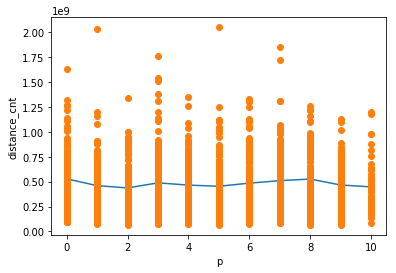

In [70]:
line(data, "p", "distance_cnt")

In [71]:
data[0]

{'LSH_count': 15,
 'NMI': 0.8840785563139981,
 'bucket width': 5.0,
 'bucketWidthsAuto': False,
 'centroidNaive_count': 197,
 'distance_cnt': 393524788,
 'p': 0,
 'randomizedHashes': True,
 'runs': 90,
 'time': 9002.0,
 'time_hashing': 425.0,
 'time_initialisation': 449.0}

Calculate how many distance calculation we saved as a percentage. "distance_cnt" ist the amount of distance calculations done. "LSH_count" is the amount of calculations we saved due to a single centroid in a bucket.
"centroidNaive_count" is the amount of calculations we saved due to multiple centroids in a bucket.

In [74]:
counts =list(map(
    sum, 
    zip(*list(seq(data).map(
        lambda x: (x["distance_cnt"], x["LSH_count"], x["centroidNaive_count"])))
       )
      )
    )
print((counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2]))

0.00020807256087490187


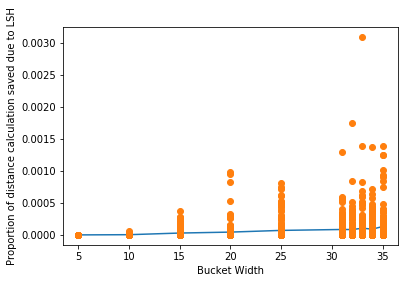

In [114]:

grouped = seq(data).filter(lambda x: x["bucket width"] != -1).group_by(lambda data: data["bucket width"]).sorted(lambda x: x[0])
x_data = grouped.map(lambda data: data[0])
y_data_averaged = grouped.map(lambda data: 
                              sum([line["LSH_count"] for line in data[1]]) / sum([line["distance_cnt"] for line in data[1]]))
x_data_flat = grouped.flat_map(lambda data: [data[0] for _ in data[1]])
y_data_flat = grouped.flat_map(lambda data: [line["LSH_count"]/line["distance_cnt"] for line in data[1]])

plt.plot(list(x_data), list(y_data_averaged))
plt.plot(list(x_data_flat), list(y_data_flat), "o")

plt.xlabel("Bucket Width")
plt.ylabel("Proportion of distance calculation saved due to LSH")
plt.savefig("figures/bucket_width_distance_saved.png", dpi=300)
plt.show()

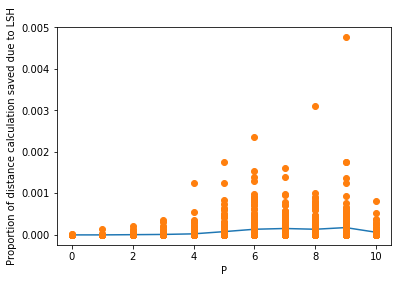

In [115]:

grouped = seq(data).group_by(lambda data: data["p"]).sorted(lambda x: x[0])
x_data = grouped.map(lambda data: data[0])
y_data_averaged = grouped.map(lambda data: 
                              sum([line["LSH_count"] for line in data[1]]) / sum([line["distance_cnt"] for line in data[1]]))
x_data_flat = grouped.flat_map(lambda data: [data[0] for _ in data[1]])
y_data_flat = grouped.flat_map(lambda data: [line["LSH_count"]/line["distance_cnt"] for line in data[1]])

plt.plot(list(x_data), list(y_data_averaged))
plt.plot(list(x_data_flat), list(y_data_flat), "o")

plt.xlabel("P")
plt.ylabel("Proportion of distance calculation saved due to LSH")
plt.savefig("figures/p_distance_saved.png", dpi=300)
plt.show()

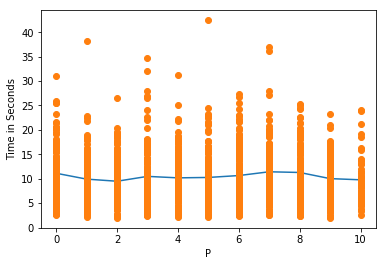

In [76]:
grouped = seq(data).group_by(lambda data: data["p"]).sorted(lambda x: x[0])
x_data = grouped.map(lambda data: data[0])
y_data_averaged = grouped.map(lambda data: sum([line["time"] / 1000 for line in data[1]]) / len(data[1]))
x_data_flat = grouped.flat_map(lambda data: [data[0] for _ in data[1]])
y_data_flat = grouped.flat_map(lambda data: [line["time"] / 1000 for line in data[1]])

plt.plot(list(x_data), list(y_data_averaged))
plt.plot(list(x_data_flat), list(y_data_flat), "o")

plt.xlabel("P")
plt.ylabel("Time in Seconds")

plt.savefig("figures/p_time.png", dpi=300)
plt.show()

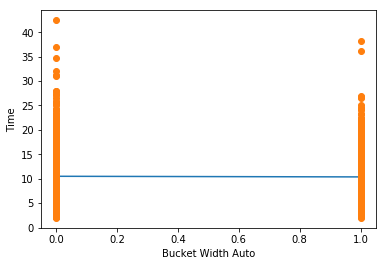

In [82]:
line(data, "bucketWidthsAuto", "time", "a_time.png", "Bucket Width Auto", "Time")

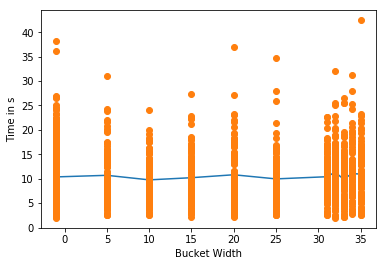

In [80]:
line(data, "bucket width", "time", "bw_time.png", "Bucket Width", "Time in s")

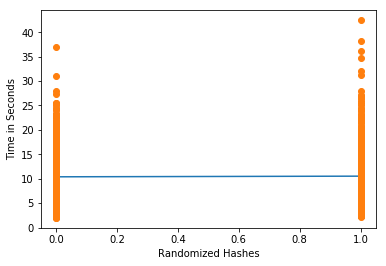

In [84]:
line(data, "randomizedHashes", "time", "r_time.png", "Randomized Hashes", "Time in Seconds")

In [ ]:
counts =list(map(
    sum, 
    zip(*list(seq(data).map(
        lambda x: (x["distance_cnt"], x["LSH_count"], x["centroidNaive_count"])))
       )
      )
    )
print((counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2]))

In [92]:
all_times = list(seq(data).map(lambda x: x["time"] / 1000))
our_time = (sum(all_times) / len(all_times))
print(our_time)

10.457763870967746


In [89]:
all_nmi = list(seq(data).map(lambda x: x["NMI"]))
print(sum(all_nmi) / len(all_nmi))

0.8643707511118339


In [91]:
data_reference = [46.208936074, 45.10983917, 44.639364292, 45.840444072, 50.761214387]
ref_time = sum(data_reference) / len(data_reference)
print(ref_time)

46.511959599


In [95]:
speedup = ref_time/our_time
print(speedup)

4.447600861224633


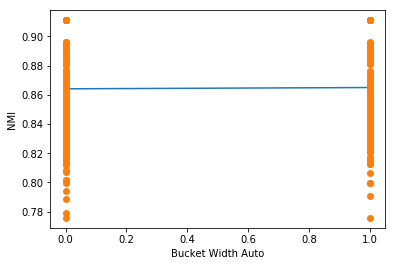

In [107]:
line(data, "bucketWidthsAuto", "NMI", "a_nmi.png", "Bucket Width Auto", "NMI")

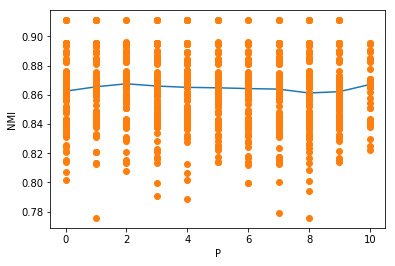

In [108]:
line(data, "p", "NMI", "p_nmi.png", "P", "NMI")

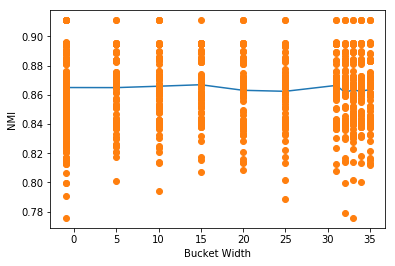

In [109]:
line(data, "bucket width", "NMI", "bw_nmi.png", "Bucket Width", "NMI")

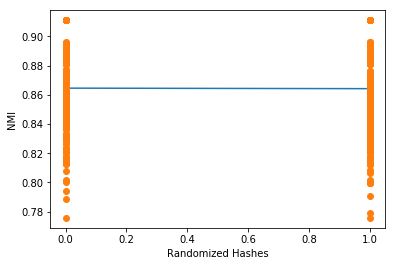

In [110]:
line(data, "randomizedHashes", "NMI", "rh_nmi.png", "Randomized Hashes", "NMI")